# Entendimento do Negócio
- *Tema:*
> Análise de Sobreviventes do Titanic: Machine Learning From Disaster - Kaggle.
- *Problema:*
> Avaliar e modelar os dados de modo a ser possível atingir o objetivo.
- *Objetivo:*
> Predizer a sobrevivência de integrantes cujo não possuem esta informação.

# Entendimento dos Dados
- *Formato*:
> Temos dois arquivos sendo um com os dados de sobreviência, para treino, e outro sem estes dados, para predição.
- *Tamanho*:
> São 1309 registros.
- *Tipo dos Dados*:
> Os dados são formados por 12 atributos onde 5 são categóricos e 7 quantitativos.

# Definição de  Bibliotecas

In [72]:
import numpy as np

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Avaliação dos Dados

In [73]:
treino = pd.read_csv('../data/train.csv')
teste = pd.read_csv('../data/test.csv')

### Avaliação de Nulos

In [74]:
treino_nulos = treino.isnull().sum()
teste_nulos = teste.isnull().sum()
pd.concat([treino_nulos, teste_nulos], axis=1).rename({0: 'treino', 1: 'teste'}, axis=1)

,treino,teste
PassengerId,0,0.0
Survived,0,NaN
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,86.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,1.0


### Concatenação para Engenharia de Dados

In [75]:
dados = pd.concat([treino, teste])
dados.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [76]:
ATRIBUTOS = dados.columns.values

In [77]:
del treino, teste

In [78]:
dados.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### Funções Gerais

In [79]:
RANDOM_STATE = 1

M_CLASSIFICACAO = [
    {
        'modelo': AdaBoostClassifier,
        'parametros': {
            'n_estimators':[10, 25, 50],
            'learning_rate': [0.001, 0.01, ],
            'algorithm':['SAMME.R','SAMME'],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': BaggingClassifier,
        'parametros': {
            'n_estimators':[5, 10, 50],
            'max_samples': [0.5, 1.0],
            'max_features': [0.1, 0.5],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': ExtraTreesClassifier,
        'parametros': {
            'n_estimators':[50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 1],
            'min_samples_split': [1, 2],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': GradientBoostingClassifier,
        'parametros': {
            'loss':['deviance', 'exponential'],
            'learning_rate': [0.001, 0.01],
            'n_estimators': [100, 150],
            'subsample': [1.0, 1.5],
            'criterion': ['friedman_mse', 'mse', 'mae'],
            'max_depth': [3, 5],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': RandomForestClassifier,
        'parametros': {
            'n_estimators':[50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 1],
            'min_samples_split': [1, 2],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': RidgeClassifier,
        'parametros': {
            'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            'random_state': [RANDOM_STATE]
        }
    },
    {
        'modelo': SGDClassifier,
        'parametros': {
            'loss': ['hinge', 'log', 'perceptron', 'huber', 'squared_loss'],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'random_state': [RANDOM_STATE]
        }
    }
]

def avaliacao_hiper_modelos(modelo: list, treino_teste: list, divisoes: int = 10) -> pd.DataFrame:
    resultado = list()
    gscv = GridSearchCV(estimator=modelo['modelo'](), param_grid=modelo['parametros'], n_jobs=-1, scoring='accuracy',
                        cv=KFold(n_splits=divisoes, random_state=RANDOM_STATE), verbose=1)
    gscv.fit(treino_teste[0], treino_teste[2])
    pred = gscv.predict(treino_teste[1])
    resultado.append({
        'modelo': str(modelo['modelo']).split('.')[-1][:-2],
        'parametros': gscv.best_params_,
        'precisao': gscv.best_score_,
        'predicao': pred,
        'instancia': gscv
    })
    return pd.DataFrame(resultado)

def avaliar_modelos(modelos: list, treino_teste: list) -> pd.DataFrame:
    resultado = list()
    for modelo in modelos:
        clf = modelo['modelo']()
        clf.fit(treino_teste[0], treino_teste[2])
        resultado.append({
            'modelo':str(modelo['modelo']).split('.')[-1][:-2],
            'precisao': accuracy_score(treino_teste[3], clf.predict(treino_teste[1])),
        })
    return pd.DataFrame(resultado)

def exibir_relacoes(dados: pd.DataFrame) -> None:
    plt.figure(dpi=96)
    sns.heatmap(dados.corr(), annot=True, cmap='viridis', fmt='.2f')
    plt.title('Relação Entre Atributos');

## Sexo (Sex)

In [80]:
dados['SexId'] = dados.Sex.map({'female': 0, 'male': 1})

## Tarifa (Fare)
- Nulos? Como solucionar?
> Conforme avaliado abaixo, estarei utilizando a mediana da tarifa por pessoa dentro da classe ao qual se encontra.
- A Classe Social (Pclass) influencia na tarifa?
> Sim.
- A tarifa (Fare) está relacionada ao ingresso (Ticket)? O ingresso é individual?
> Sim. Vemos que a tarifa cobrada foi por ingresso, e não, o mesmo não é individual.
> Como visto no gráfico, temos até 11 pessoas compartilhando um mesmo ingresso.
- A média de preço do ingresso individual é o mesmo para ingressos utilizados por múltiplas indíviduos?
> Não. Nota-se que conforme aumenta o número de indivíduos, a média da tarifa do ingresso também aumenta dentro da classe, o qual confirma a tarifa por ingresso.
> Ou seja, quando analisado sem o devido agrupamento dos ingressos, avaliamos a tarifa do mesmo ingresso por até 11x.
> Deste modo, afim de evitarmos problemas, substituirei o atributo Tarifa (Fare) pelo atributo Tarifa Individual (IndividualRate) dividindo a mesma pelo número de pessoas que utilizaram o ingresso.

In [81]:
dados.loc[dados.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexId
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1


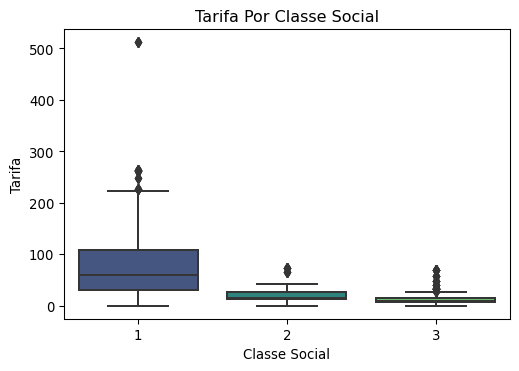

In [82]:
plt.figure(dpi=96)
sns.boxplot(x='Pclass', y='Fare', data=dados, palette='viridis')
plt.title('Tarifa Por Classe Social')
plt.xlabel('Classe Social')
plt.ylabel('Tarifa');

In [83]:
dados1 = dados[['PassengerId', 'Ticket']].groupby('Ticket').count().rename({'PassengerId': 'AmountOfPeople'}, axis=1)

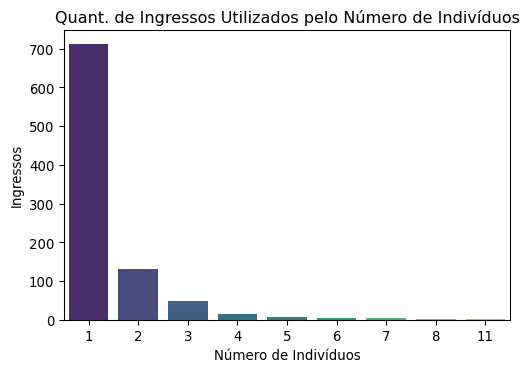

In [84]:
plt.figure(dpi=96)
sns.barplot(x='AmountOfPeople', y='Ticket', data=dados1.reset_index().groupby('AmountOfPeople').count().reset_index(), palette='viridis')
plt.title('Quant. de Ingressos Utilizados pelo Número de Indivíduos')
plt.xlabel('Número de Indivíduos')
plt.ylabel('Ingressos');

In [85]:
dados1.reset_index(inplace=True)
dados1['Pclass'], dados1['Fare'] = zip(* dados1.Ticket.apply(lambda ingresso: [dados.Pclass.loc[dados.Ticket==ingresso].min(), dados.Fare.loc[dados.Ticket==ingresso].mean()]))

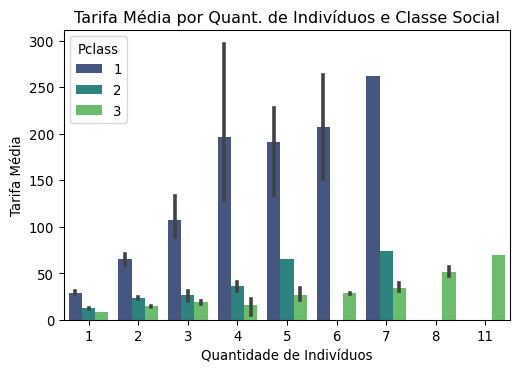

In [86]:
plt.figure(dpi=96)
sns.barplot(x='AmountOfPeople', y='Fare', hue='Pclass', data=dados1, palette='viridis')
plt.title('Tarifa Média por Quant. de Indivíduos e Classe Social')
plt.xlabel('Quantidade de Indivíduos')
plt.ylabel('Tarifa Média');

In [87]:
dados1 = dados[['Pclass', 'Ticket', 'Fare']].groupby(['Ticket', 'Pclass']).mean().reset_index()

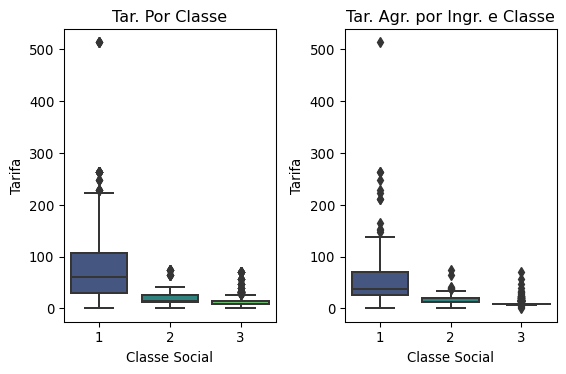

In [88]:
fig, [ax0, ax1] = plt.subplots(1, 2, dpi=96)
sns.boxplot(x='Pclass', y='Fare', data=dados, palette='viridis', ax=ax0)
ax0.set_title('Tar. Por Classe')
ax0.set_xlabel('Classe Social')
ax0.set_ylabel('Tarifa')

sns.boxplot(x='Pclass', y='Fare', data=dados1, palette='viridis', ax=ax1)
ax1.set_title('Tar. Agr. por Ingr. e Classe')
ax1.set_xlabel('Classe Social')
ax1.set_ylabel('Tarifa')
plt.tight_layout();

### Correção de Outliers

In [89]:
def definir_tarifa_individual(args):
    return args[1] / dados.PassengerId.loc[dados.Ticket==args[0]].count()

def ajustar_correcao_outliers(args):
    tarifa, tarifas = args[0], dados.IndividualRate.loc[dados.Pclass==args[1]]
    q1, q3 = tarifas.quantile(.25), tarifas.quantile(.75)
    limite_inferior = q1 - 1.5 * (q3 - q1)
    limite_superior = q3 + 1.5 * (q3 - q1)
    return tarifas.median() if tarifa < limite_inferior or tarifa > limite_superior else tarifa

dados['IndividualRate'] = dados[['Ticket', 'Fare']].apply(definir_tarifa_individual, axis=1)
dados['IndividualRate'] = dados[['IndividualRate', 'Pclass']].apply(ajustar_correcao_outliers, axis=1)

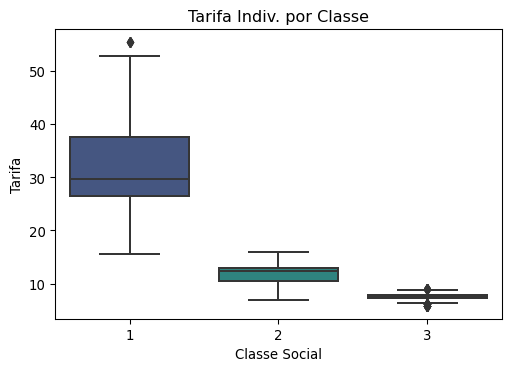

In [90]:
plt.figure(dpi=96)
sns.boxplot(x='Pclass', y='IndividualRate', data=dados, palette='viridis')
plt.title('Tarifa Indiv. por Classe')
plt.xlabel('Classe Social')
plt.ylabel('Tarifa');

### Correção de Nulos

In [91]:
dados.IndividualRate.fillna(dados.IndividualRate.loc[dados.Pclass==3].median(), inplace=True)

### Exclusões de Itens Desnecessários

In [92]:
dados.drop('Fare', axis=1, inplace=True)
del ax0, ax1, dados1, fig

## Embarque (Embarked)
- Nulos? Como solucionar?
> Devido há ausência de melhores informações, estarei utilizando o embarque padrão.
- Qual a relação de Embarque com os demais atributos?
> Conforme gráfico, não há uma relação forte com os demais atributos.
- Ingresso (Ticket) influencia no Embarque?
> Não. Vemos na lista de Ingressos (Ticket) próximos que apenas 2 registros do mesmo padrão de ingresso apresentam embarque diferente de 'S'

In [93]:
dados.loc[dados.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,SexId,IndividualRate
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,B28,NaN,0,40.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,B28,NaN,0,40.0


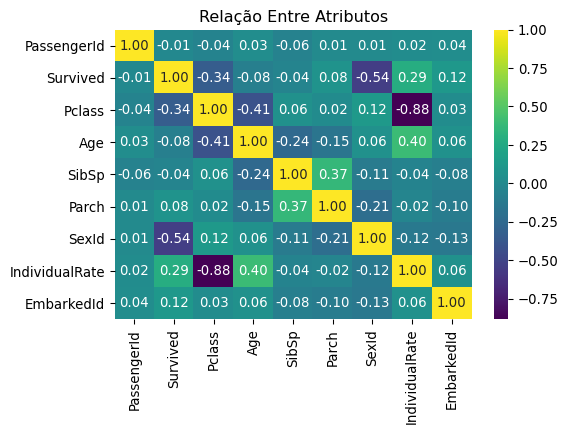

In [94]:
dados['EmbarkedId'] = dados.Embarked.map({embarque: indx for indx, embarque in enumerate(dados.Embarked.unique().tolist())})
exibir_relacoes(dados)

In [95]:
ingresso = 113572
dados1 = dados.loc[dados.Ticket.str.isdecimal()].copy()
dados1.Ticket = dados1.Ticket.astype('int64')
dados2 = dados1[['Ticket', 'Embarked']].loc[dados1.Ticket<ingresso].sort_values('Ticket').tail(5)
dados3 = dados1[['Ticket', 'Embarked']].loc[dados1.Ticket>ingresso].sort_values('Ticket').head(5)
dados1 = pd.concat([dados2, dados3])
print('Lista de Ingressos próximos ao', ingresso)
dados1

Lista de Ingressos próximos ao 113572


,Ticket,Embarked
166,113505,S
26,113509,C
54,113509,C
351,113510,S
252,113514,S
390,113760,S
802,113760,S
435,113760,S
763,113760,S
185,113767,S


### Correção de Nulos

In [96]:
dados.Embarked.fillna(dados.Embarked.mode().values[0], inplace=True)
dados['EmbarkedId'] = dados.Embarked.map({embarque: indx for indx, embarque in enumerate(dados.Embarked.unique().tolist())})

### Exclusão de Itens Desnecessários

In [97]:
del dados1, dados2, dados3, ingresso

## Cabine (Cabin)
- Nulos? Como solucionar?
> Devido há ausência de dados superior a 50%, estou excluindo este atributo.

In [98]:
nulos = dados.Cabin.isnull().sum()
print('Cabin:', nulos, nulos / dados.PassengerId.count())

Cabin: 1014 0.774637127578304


### Exclusão de Itens Desnecessários

In [99]:
dados.drop('Cabin', axis=1, inplace=True)
del nulos

## Idade (Age)
- Nulos? Como solucionar?
> Conforme identificado, este campo não terá grandes resultados utilizando modelos de regressão linear.
> Deste modo, criei um atributo para classificação entre crianças, jovens, adultos, idosos.
- Há relações fortes com outros atributos?
> Vejo boas relações com Pclass e IndividualRate, e também a possibilidade do desenvolvimento de atributos que podem ser pertinentes a este, tais como:
    > - Married (Casado): Identifiquei que os indivíduos do sexo feminino, quando casadas, traz como primeiro nome o nome do esposo, portanto, criei o atributo Família (FamilyName)
    > composto pelo primeiro nome e sobrenome. Quando encontrado 2 indivíduos com o mesmo nome de família, identificamos o casal.
    > - Widowers (Viúvo): Avaliando o atributo Casado (Married), notei que indivíduos do sexo feminino nesta situação, possuem o Título (Title) de 'Mrs', porém
    > nem toda Senhora (Mrs) está acompanhada de seu marido (Família / FamilyName). Avaliei a média de idade destes indivíduos e notei que estão próximos aos 40 anos,
    > o qual, me permite supor que estes indivíduos possam ser Viúvas.
    > - Responsable (Responsável): Este atributo será o responsável por informar se o indivíduo é responsável por si mesmo ou dependente de alguém (Criança).

In [100]:
dados.loc[dados.Age.isnull()].sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,SexId,IndividualRate,EmbarkedId
170,1062,NaN,3,"Lithman, Mr. Simon",male,NaN,0,0,S.O./P.P. 251,S,1,7.55,0
380,1272,NaN,3,"O'Connor, Mr. Patrick",male,NaN,0,0,366713,Q,1,7.75,2


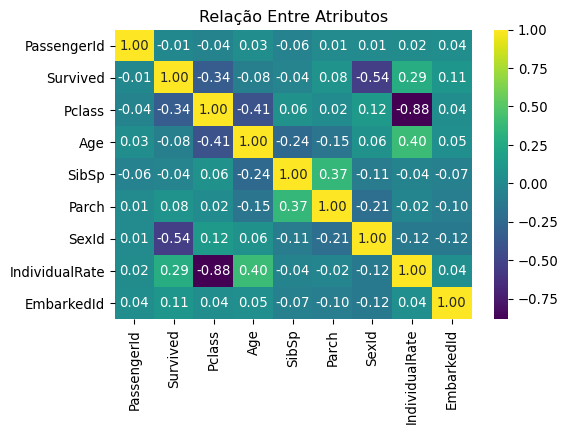

In [101]:
exibir_relacoes(dados)

### Criação de Atributos:
- LastName
- Title
- FamilyName
- Married
- Widowers
- Responsable

In [102]:
def extracao_atributos(nome_completo):
    avaliacao, nomes, itens = [',', '.', '('], [], [None, nome_completo]

    for indx in range(len(avaliacao)):
        itens = itens[1].split(avaliacao[indx])
        nomes.append(itens[0].strip().split(' ')[0] if indx < 2 else ' '.join([itens[0].strip().split(' ')[0], nomes[0]]))

    return nomes

dados['LastName'], dados['Title'], dados['FamilyName'] = zip(* dados.Name.apply(extracao_atributos))

In [103]:
def definir_casados(args):
    return [1, 0, 1] if not args[1] in ['Master', 'Miss'] and dados.PassengerId.loc[(dados.FamilyName==args[0]) & ((dados.Title!='Master') | (dados.Title!='Miss'))].count() > 1 else [0, 0, 0]

dados['Married'], dados['Widowers'], dados['Responsable'] = zip(* dados[['FamilyName', 'Title']].apply(definir_casados, axis=1))

In [104]:
def definir_viuvos(args):
    return 1 if args[0] == 'Mrs' and args[1] == 0 else 0

dados['Widowers'] = dados[['Title', 'Married']].apply(definir_viuvos, axis=1)

In [105]:
def identificar_responsaveis(args):
    ingresso, responsavel, sobrenome, familia, idade = args[0], args[1], args[2], args[3], args[4]

    if responsavel == 0:
        familia_correta = dados.FamilyName.loc[(dados.LastName==sobrenome) & (dados.Responsable==1) & (dados.Ticket==ingresso)].values
        familia, responsavel = ([familia, 1] if len(familia_correta) == 0 else [familia_correta, responsavel]) if pd.isna(idade) \
            else ([familia, 0] if len(familia_correta) == 0 and idade < 14 else ([familia, 1] if len(familia_correta) == 0 else [familia_correta[0], responsavel]))
    return familia, responsavel

dados['FamilyName'], dados['Responsable'] = zip(* dados[['Ticket', 'Responsable', 'LastName', 'FamilyName', 'Age']].apply(identificar_responsaveis, axis=1))

/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


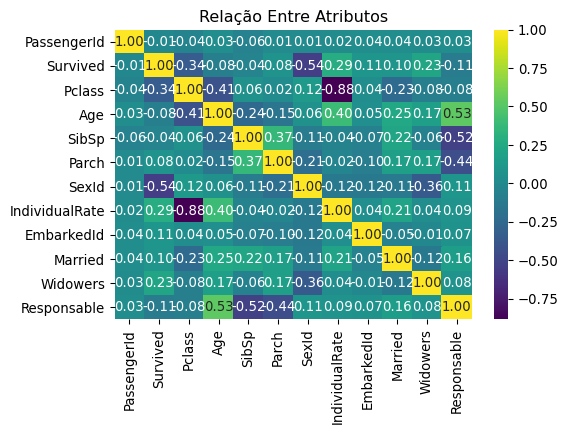

In [106]:
exibir_relacoes(dados)

### Definição de Atributos e Visualização dos Dados

In [107]:
dados1 = dados.copy()
dados1.set_index('PassengerId', inplace=True)
dados1.drop([atributo for atributo in dados1.columns.values if dados1[atributo].dtype=='O'], axis=1, inplace=True)
dados1.drop(['Survived', 'SibSp', 'Parch', 'SexId', 'EmbarkedId'], axis=1, inplace=True)
dados1.dropna(inplace=True)

In [108]:
X = dados1.drop('Age', axis=1)
y = dados1.Age

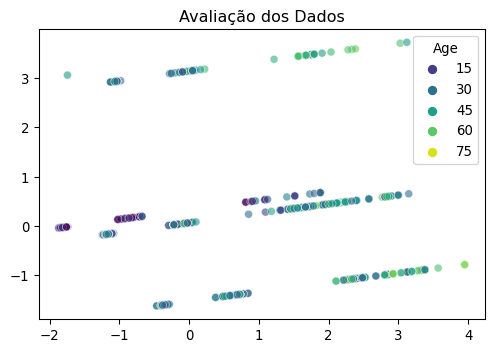

In [109]:
X_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(StandardScaler().fit_transform(X))
plt.figure(dpi=96)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='viridis', alpha=.6)
plt.title('Avaliação dos Dados');

### Criação de Atributos:
- AgeGroup

In [110]:
# Avaliando a menor idade de um indivíduo casado.
dados.Age.loc[(dados.Married==1) & (~dados.Age.isnull())].min()

14.0

In [111]:
# FAIXA_ETARIA = ['Criança', 'Adolescente', 'Adulto', 'Idoso']
# dados['AgeGroup'], dados['AgeGroupId'] = zip(* dados.Age.apply(lambda idade: [FAIXA_ETARIA[0], 0] if idade < 14 else (
#     [FAIXA_ETARIA[1], 1] if idade < 21 else (
#         [FAIXA_ETARIA[2], 2] if idade < 60 else (
#             [FAIXA_ETARIA[3], 3] if not pd.isna(idade) else [pd.NA, np.nan])
#     )
# )))
FAIXA_ETARIA = ['Criança', 'Adulto', 'Idoso']
dados['AgeGroup'], dados['AgeGroupId'] = zip(* dados.Age.apply(lambda idade: [FAIXA_ETARIA[0], 0] if idade < 14 else (
        [FAIXA_ETARIA[1], 1] if idade < 60 else (
            [FAIXA_ETARIA[2], 2] if not pd.isna(idade) else [pd.NA, np.nan])
    )
))

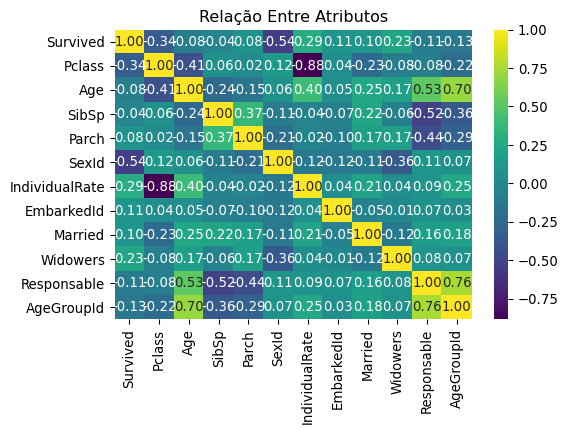

In [112]:
dados.set_index('PassengerId', inplace=True)
dados1 = dados.copy()
exibir_relacoes(dados1)

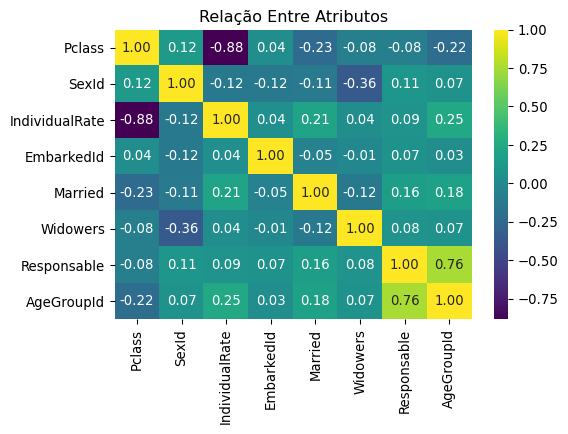

In [113]:
dados1.drop([atributo for atributo in dados1.columns.values if dados1[atributo].dtype=='O'], axis=1, inplace=True)
dados1.drop(['Survived', 'Age', 'SibSp', 'Parch'], axis=1, inplace=True)
exibir_relacoes(dados1)

In [114]:
treino = dados1.dropna()
teste = dados1.loc[dados1.AgeGroupId.isnull()].drop('AgeGroupId', axis=1)

/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


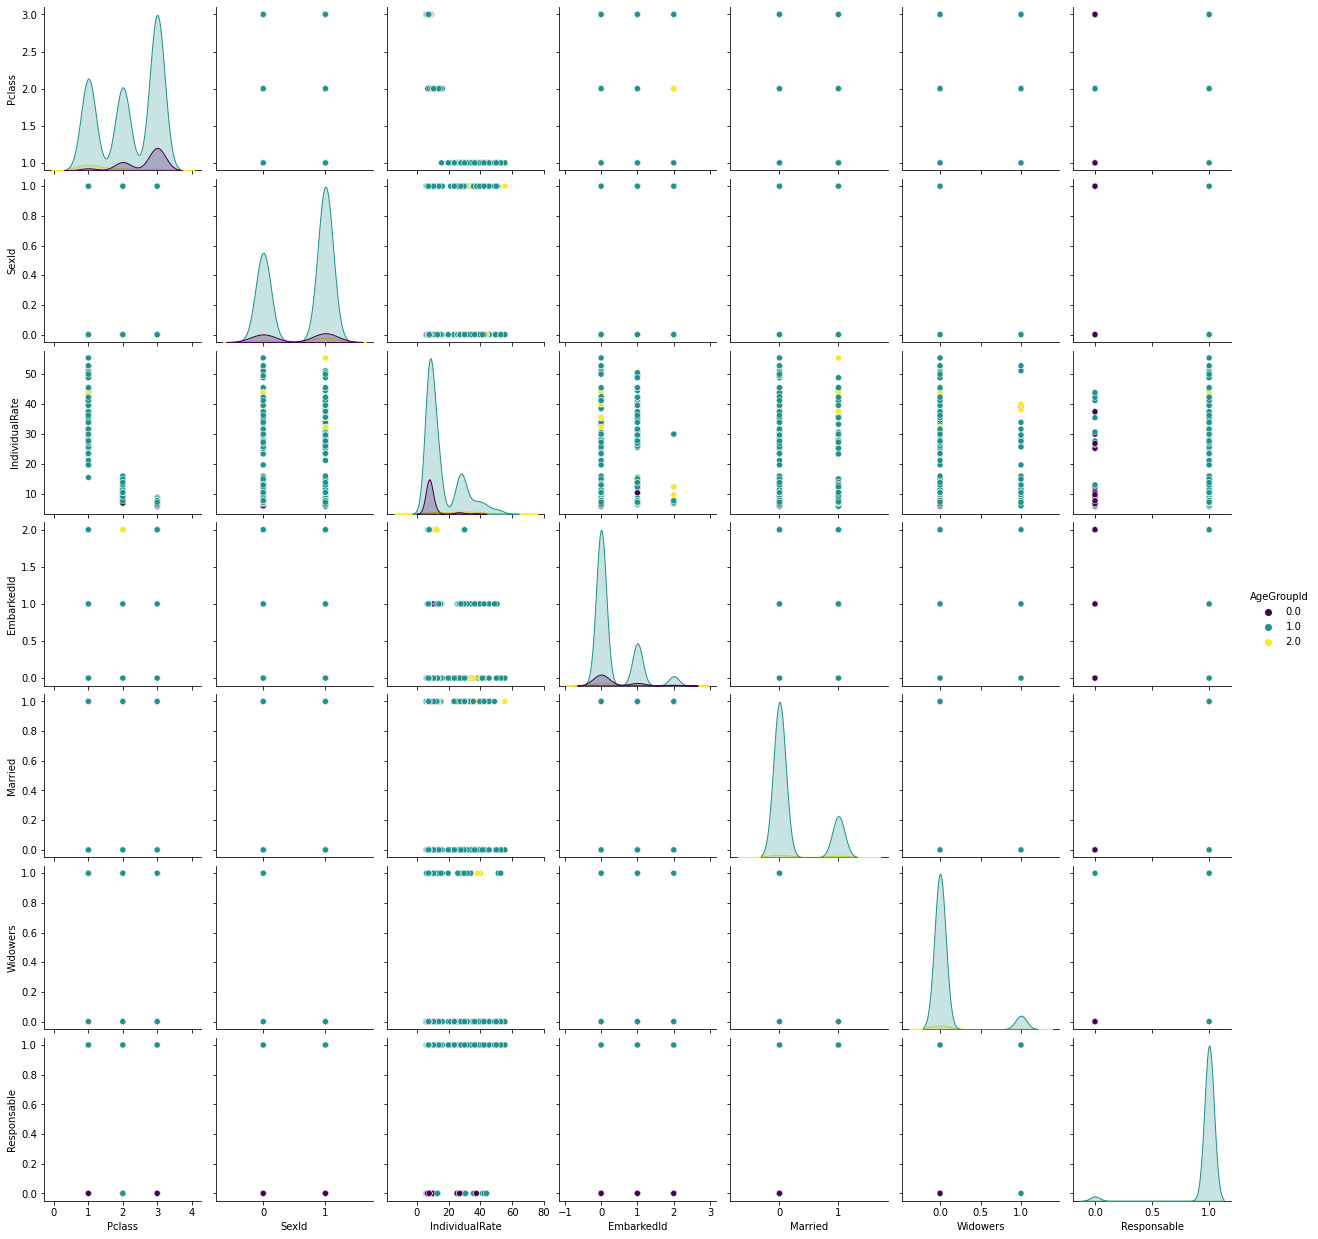

In [115]:
sns.pairplot(treino, hue='AgeGroupId', palette='viridis');

In [116]:
X = treino.drop('AgeGroupId', axis=1)
y = treino.AgeGroupId

In [117]:
std = StandardScaler()
X_normalizado = std.fit_transform(X)

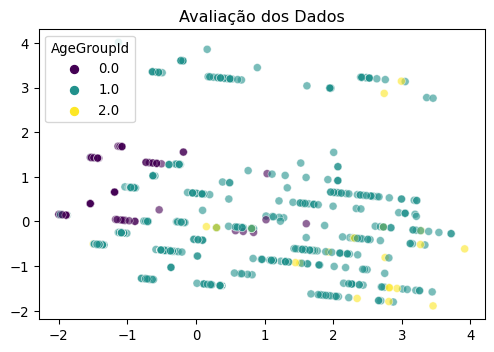

In [118]:
X_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_normalizado)
plt.figure(dpi=96)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=.6)
plt.title('Avaliação dos Dados');

### Correção de Nulos

In [119]:
treino_teste = train_test_split(X_normalizado, y, test_size=.3, random_state=RANDOM_STATE)

In [120]:
avaliacao = avaliar_modelos(M_CLASSIFICACAO, treino_teste).sort_values('precisao', ascending=False)
avaliacao

,modelo,precisao
0,AdaBoostClassifier,0.929936
6,SGDClassifier,0.923567
1,BaggingClassifier,0.910828
3,GradientBoostingClassifier,0.910828
4,RandomForestClassifier,0.910828
2,ExtraTreesClassifier,0.907643
5,RidgeClassifier,0.904459


#### Avaliação dos Melhores Modelos com hiper Parâmetros

In [121]:
modelo = avaliacao.loc[avaliacao.precisao==avaliacao.precisao.max()].index.values[0]
df_hiper = avaliacao_hiper_modelos(modelo=M_CLASSIFICACAO[modelo], divisoes=50, treino_teste=treino_teste)
print(df_hiper['parametros'].values[-1])
df_hiper[['modelo', 'precisao']]

/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.9s finished


Fitting 50 folds for each of 12 candidates, totalling 600 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 10, 'random_state': 1}


,modelo,precisao
0,AdaBoostClassifier,0.952667


### Matriz de Confusão

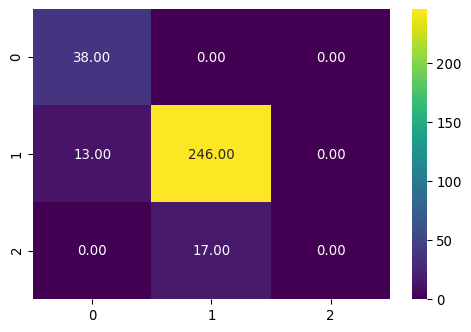

In [122]:
plt.figure(dpi=96)
sns.heatmap(confusion_matrix(treino_teste[3].values, df_hiper['predicao'].values[-1]), annot=True, cmap='viridis', fmt='.2f');

In [123]:
y = std.transform(teste)
predicao = pd.DataFrame(df_hiper['instancia'].values[-1].predict(y), columns=['AgeGroupId'])

In [124]:
teste1 = pd.concat([teste.reset_index(), predicao], axis=1).set_index('PassengerId')
dados1 = pd.concat([treino, teste1])
dados1 = dados1.AgeGroupId
dados.drop('AgeGroupId', axis=1, inplace=True)
dados = pd.concat([dados, dados1], axis=1)
dados.isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Embarked            0
SexId               0
IndividualRate      0
EmbarkedId          0
LastName            0
Title               0
FamilyName          0
Married             0
Widowers            0
Responsable         0
AgeGroup          263
AgeGroupId          0
dtype: int64

In [125]:
dados.AgeGroup.loc[dados.AgeGroup.isnull()] = dados.AgeGroupId.loc[dados.AgeGroup.isnull()].map({indx: FAIXA_ETARIA[indx] for indx in range(len(FAIXA_ETARIA))})

/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Exclusão de Itens Desnecessários

In [126]:
del df_hiper, avaliacao, y, treino, teste1, teste, predicao, treino_teste, dados1, X_normalizado, X_pca, X

## Sobreviveu (Survived)
- Nulos? Como solucionar?
- Quais foram as tendências de sobrevivência quanto ao sexo?
> Homens, apesar de estar em maior quantidade, tendem a não sobreviver quando em relação as mulheres.
- As classes influenciam na sobrevivência?
> Conforme visto, 3ª classe tende a não sobreviver, porém 1ª classe e 2ª classe seguem bem próximas.
- Faixa etária tem influência na sobrevivência? E isto se mantém dentro das classes?
> Visto que apenas crianças (< 14) tenderam a sobreviver. Não, todas as faixas exceto os idosos tendem a sobreviver na 1ª classe.
> A 2ª classe tende a seguir o modelo indiferente de classes e 3ª classe tende a não sobreviver.

In [127]:
dados.sample(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,SexId,IndividualRate,EmbarkedId,LastName,Title,FamilyName,Married,Widowers,Responsable,AgeGroup,AgeGroupId
PassengerId,,,,,,,,,,,,,,,,,,,,
347,1.0,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,S,0,13.000000,0,Smith,Miss,Marion Smith,0,0,1,Adulto,1.0
1286,NaN,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,S,1,7.341667,0,Kink-Heilmann,Mr,Anton Kink-Heilmann,1,0,1,Adulto,1.0


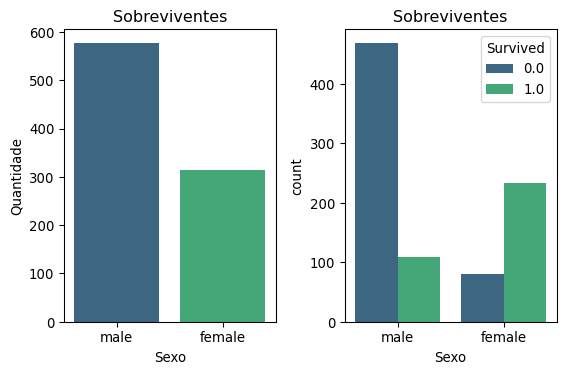

In [128]:
fig, [ax0, ax1] = plt.subplots(1, 2, dpi=96)

sns.countplot(x='Sex', data=dados[['Sex']].loc[~dados.Survived.isnull()], ax=ax0, palette='viridis')
ax0.set_title('Sobreviventes')
ax0.set_ylabel('Quantidade')
ax0.set_xlabel('Sexo')

sns.countplot(x='Sex', hue='Survived', data=dados[['Survived', 'Sex']].loc[~dados.Survived.isnull()], ax=ax1, palette='viridis')
ax1.set_title('Sobreviventes')
ax1.set_xlabel('Sexo')

plt.tight_layout();

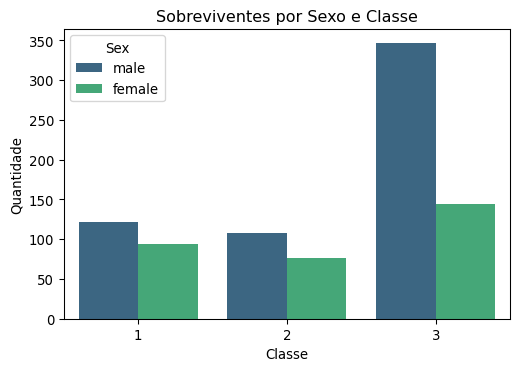

In [129]:
plt.figure(dpi=96)
sns.countplot(x='Pclass', hue='Sex', data=dados[['Pclass', 'Sex']].loc[~dados.Survived.isnull()], palette='viridis')
plt.title('Sobreviventes por Sexo e Classe')
plt.xlabel('Classe')
plt.ylabel('Quantidade');

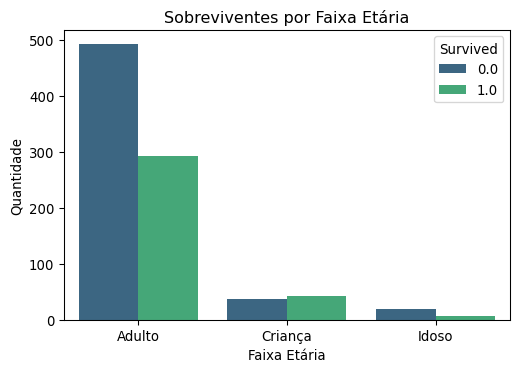

In [130]:
plt.figure(dpi=96)
sns.countplot(x='AgeGroup', hue='Survived', data=dados[['AgeGroup', 'Survived']].loc[~dados.Survived.isnull()], palette='viridis')
plt.title('Sobreviventes por Faixa Etária')
plt.ylabel('Quantidade')
plt.xlabel('Faixa Etária');

<Figure size 576x384 with 0 Axes>

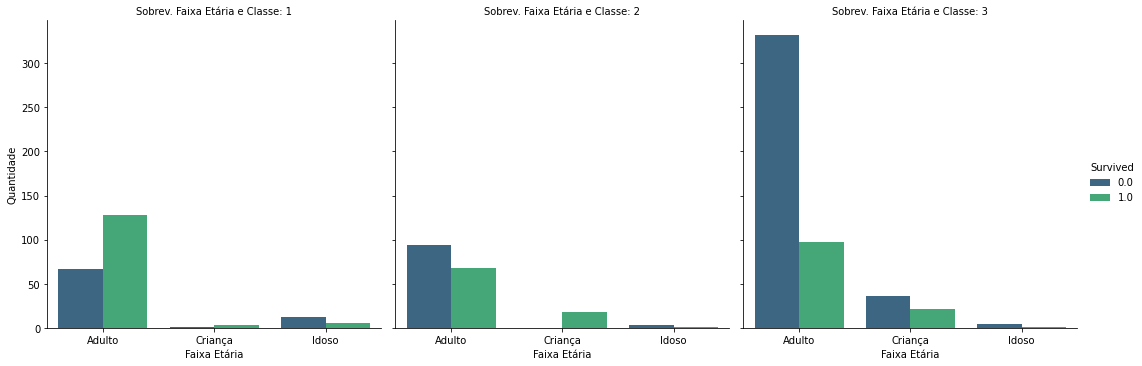

In [131]:
plt.figure(dpi=96)
g = sns.catplot(x='AgeGroup', col='Pclass', hue='Survived', data=dados[['AgeGroup', 'Pclass', 'Survived']].loc[~dados.Survived.isnull()], palette='viridis', kind='count')
g.set_axis_labels('Faixa Etária', 'Quantidade')
g.set_titles('Sobrev. Faixa Etária e Classe: {col_name}')

In [132]:
dados.isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Embarked            0
SexId               0
IndividualRate      0
EmbarkedId          0
LastName            0
Title               0
FamilyName          0
Married             0
Widowers            0
Responsable         0
AgeGroup            0
AgeGroupId          0
dtype: int64

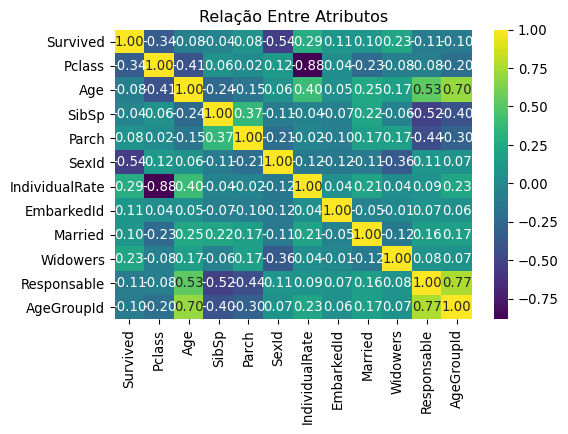

In [133]:
exibir_relacoes(dados)

In [134]:
dados1 = dados.drop([atributo for atributo in dados.columns.values if dados[atributo].dtype=='O'], axis=1)
dados1.drop(['Age','SibSp', 'Parch'], axis=1, inplace=True)

In [135]:
treino = dados1.loc[~dados1.Survived.isnull()]
X = treino.drop('Survived', axis=1)
y = treino.Survived
teste = dados1.loc[dados1.Survived.isnull()].drop('Survived', axis=1)

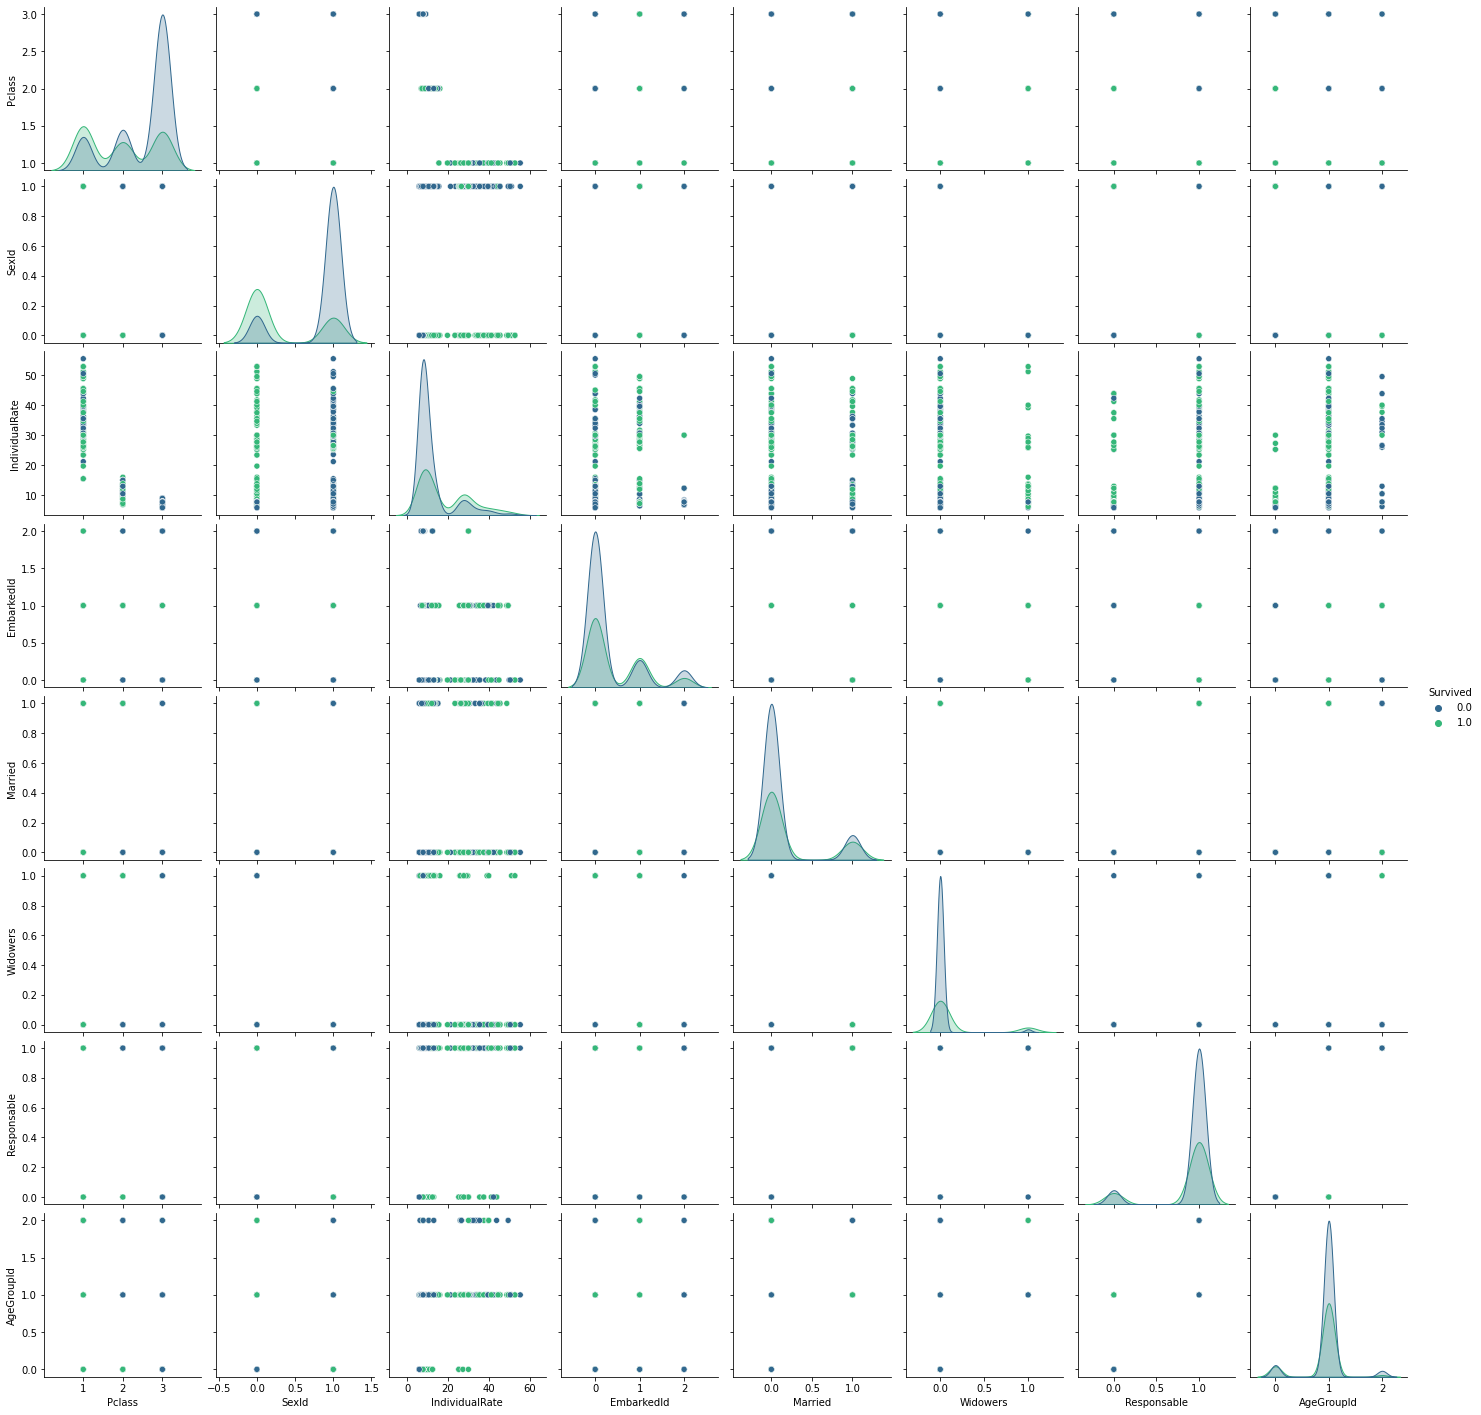

In [136]:
sns.pairplot(treino, hue='Survived', palette='viridis');

In [137]:
X_normalizado = std.fit_transform(X)
treino_teste = train_test_split(X_normalizado, y, test_size=.2, random_state=RANDOM_STATE)

In [138]:
avaliacao = avaliar_modelos(M_CLASSIFICACAO, treino_teste=treino_teste)
avaliacao.sort_values('precisao', ascending=False)

,modelo,precisao
0,AdaBoostClassifier,0.815642
3,GradientBoostingClassifier,0.810056
1,BaggingClassifier,0.804469
4,RandomForestClassifier,0.804469
2,ExtraTreesClassifier,0.787709
5,RidgeClassifier,0.776536
6,SGDClassifier,0.748603


In [139]:
modelo = avaliacao.loc[avaliacao.precisao==avaliacao.precisao.max()].index.values[0]
df_hiper = avaliacao_hiper_modelos(modelo=M_CLASSIFICACAO[modelo], divisoes=50, treino_teste=treino_teste)
print(df_hiper['parametros'].values[-1])
df_hiper[['modelo', 'precisao']]

/home/kleberbaldan/.anaconda3/envs/Titanic-MLD/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   28.6s finished


Fitting 50 folds for each of 12 candidates, totalling 600 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 10, 'random_state': 1}


,modelo,precisao
0,AdaBoostClassifier,0.790476


### Matriz de Confusão

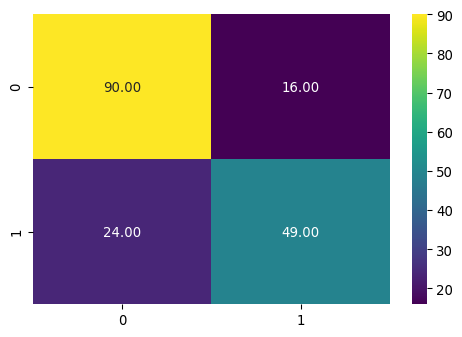

In [140]:
plt.figure(dpi=96)
sns.heatmap(confusion_matrix(treino_teste[3].values, df_hiper['predicao'].values[-1]), annot=True, cmap='viridis', fmt='.2f');

In [141]:
y = std.transform(teste)
predicao = pd.DataFrame(df_hiper['instancia'].values[-1].predict(y), columns=['Survived'])

In [142]:
teste1 = pd.concat([teste.reset_index(), predicao], axis=1).set_index('PassengerId')
teste1.Survived.to_csv('../data/survived.csv')